In [2]:
import os
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
# Dossiers
base_path = "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented"

images_dir = os.path.join(base_path, "images")
masks_dir = os.path.join(base_path, "masks")

# Lister et trier tous les fichiers .jpg
image_paths = sorted(glob(os.path.join(images_dir, "*.jpg")))
mask_paths = sorted(glob(os.path.join(masks_dir, "*.jpg")))

print(f"Nombre d'images : {len(image_paths)}")
print(f"Nombre de masques : {len(mask_paths)}")

Nombre d'images : 5108
Nombre de masques : 5108


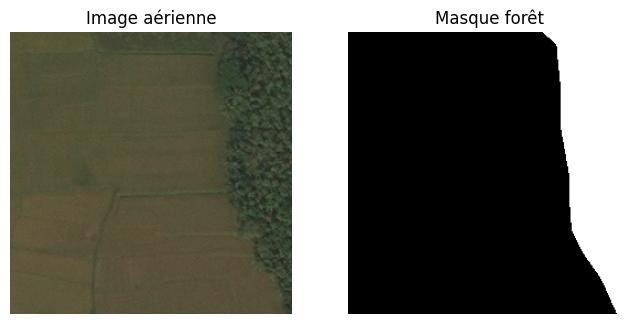

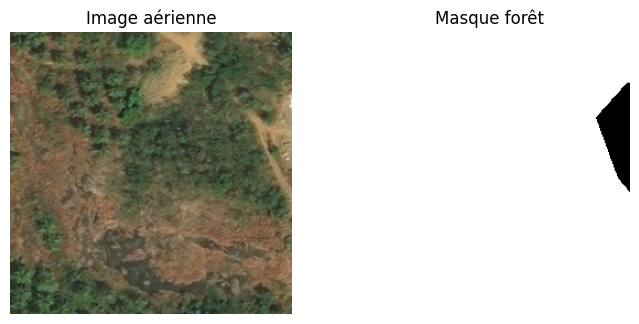

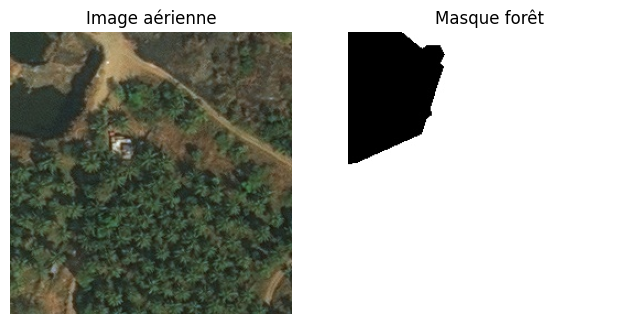

In [4]:
# Choisir 3 exemples aléatoires
for i in [0, 10, 20]:
    img = cv2.imread(image_paths[i])                 # Lire image (BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Convertir en RGB
    mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)  # Masque en niveaux de gris
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Image aérienne")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Masque forêt")
    plt.axis("off")
    
    plt.show()


In [5]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)               
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = img / 255.0                         
    return img

def preprocess_mask(mask_path, threshold=127):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.where(mask > threshold, 1, 0)    
    mask = np.expand_dims(mask, axis=-1)      
    return mask

In [8]:

# 70% train
train_size = 0.7
# 20% val
val_size = 0.2 / (1 - train_size)  # proportion de la partie restante (30%)

# Split train / temp (train 70%, temp 30%)
train_img, temp_img, train_mask, temp_mask = train_test_split(
    image_paths, mask_paths, test_size=1-train_size, random_state=42
)

# Split temp en validation et test (20% et 10% du total)
val_img, test_img, val_mask, test_mask = train_test_split(
    temp_img, temp_mask, test_size=1-(val_size), random_state=42
)

print(f"Train: {len(train_img)} images")
print(f"Validation: {len(val_img)} images")
print(f"Test: {len(test_img)} images")

Train: 3575 images
Validation: 1021 images
Test: 512 images


In [20]:
from tensorflow.keras.utils import Sequence
import albumentations as A  # bibliothèque pour augmentation
import random

# --- Définir les augmentations ---
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),         # Flip horizontal aléatoire
    A.VerticalFlip(p=0.5),           # Flip vertical aléatoire
    A.Rotate(limit=30, p=0.5),       # Rotation aléatoire jusqu'à ±30°
    A.RandomBrightnessContrast(p=0.3) # Ajustement de luminosité/contraste
])

class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, shuffle=True, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_img_paths = [self.image_paths[i] for i in batch_indexes]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indexes]
        
        X = []
        Y = []
        for img_path, mask_path in zip(batch_img_paths, batch_mask_paths):
            img = preprocess_image(img_path)
            mask = preprocess_mask(mask_path)
            
            # --- Data augmentation ---
            if self.augment:
                augmented = augmentation(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            
            X.append(img)
            Y.append(mask)
        
        return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# --- Création des générateurs ---
batch_size = 16

train_gen = DataGenerator(train_img, train_mask, batch_size=batch_size, augment=True)
val_gen = DataGenerator(val_img, val_mask, batch_size=batch_size, augment=False)
test_gen = DataGenerator(test_img, test_mask, batch_size=batch_size, shuffle=False, augment=False)


In [21]:
X_batch, Y_batch = train_gen[0]
print("Shape X_batch :", X_batch.shape)
print("Shape Y_batch :", Y_batch.shape)

Shape X_batch : (16, 256, 256, 3)
Shape Y_batch : (16, 256, 256, 1)


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1):
    # --- Encoder: ResNet50 pré-entraîné ---
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Extraire les features pour ASPP
    layer_names = [
        'conv4_block6_out',  # taille réduite 1/16
        'conv2_block3_out'   # taille réduite 1/4
    ]
    encoder_outputs = [base_model.get_layer(name).output for name in layer_names]

    x = encoder_outputs[0]  # conv4_block6_out

    # --- ASPP Module ---
    b0 = layers.Conv2D(256, 1, padding='same', activation='relu')(x)
    b1 = layers.Conv2D(256, 3, dilation_rate=6, padding='same', activation='relu')(x)
    b2 = layers.Conv2D(256, 3, dilation_rate=12, padding='same', activation='relu')(x)
    b3 = layers.Conv2D(256, 3, dilation_rate=18, padding='same', activation='relu')(x)
    b4 = layers.GlobalAveragePooling2D()(x)
    b4 = layers.Reshape((1, 1, b4.shape[1]))(b4)
    b4 = layers.Conv2D(256, 1, padding='same', activation='relu')(b4)
    b4 = layers.UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation='bilinear')(b4)

    x = layers.Concatenate()([b0, b1, b2, b3, b4])
    x = layers.Conv2D(256, 1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # --- Decoder ---
    low_level_features = encoder_outputs[1]  # conv2_block3_out
    low_level_features = layers.Conv2D(48, 1, padding='same', activation='relu')(low_level_features)
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    x = layers.Concatenate()([x, low_level_features])
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)

    # --- Output ---
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = layers.Conv2D(num_classes, 1, padding='same', activation=activation)(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# --- Exemple d'utilisation ---
model = DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 17,824,945 (68.00 MB)

 Trainable params: 17,793,841 (67.88 MB)

 Non-trainable params: 31,104 (121.50 KB)

In [23]:
from tensorflow.keras import backend as K

# Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# IoU
def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Compilation améliorée
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', dice_coefficient, iou_metric]
)


In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

# Entraînement
epochs = 30
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.7849 - dice_coefficient: 0.7391 - iou_metric: 0.5898 - loss: 0.4679
Epoch 1: val_loss improved from inf to 4.88519, saving model to best_model.h5
224/224 ━━━━━━━━━━━━━━━━━━━━ 198s 814ms/step - accuracy: 0.7850 - dice_coefficient: 0.7392 - iou_metric: 0.5900 - loss: 0.4677 - val_accuracy: 0.4013 - val_dice_coefficient: 0.0019 - val_iou_metric: 9.4994e-04 - val_loss: 4.8852 - learning_rate: 1.0000e-04
Epoch 2/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8305 - dice_coefficient: 0.7893 - iou_metric: 0.6531 - loss: 0.3902
Epoch 2: val_loss did not improve from 4.88519
224/224 ━━━━━━━━━━━━━━━━━━━━ 158s 705ms/step - accuracy: 0.8305 - dice_coefficient: 0.7893 - iou_metric: 0.6531 - loss: 0.3902 - val_accuracy: 0.4013 - val_dice_coefficient: 1.0660e-04 - val_iou_metric: 5.4116e-05 - val_loss: 10.1172 - learning_rate: 1.0000e-04
Epoch 3/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.8395 - dice_coef

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


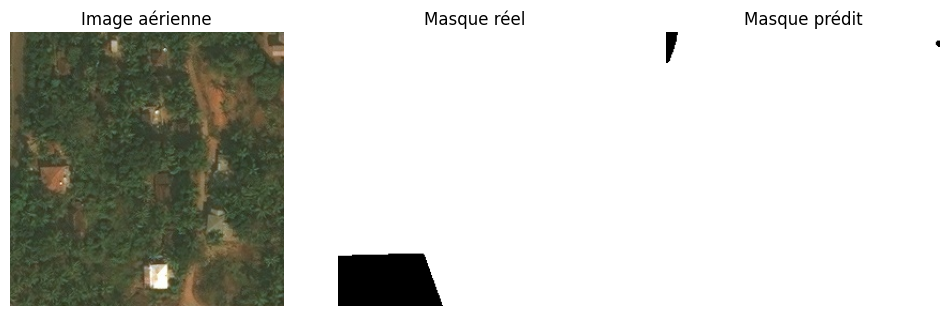

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


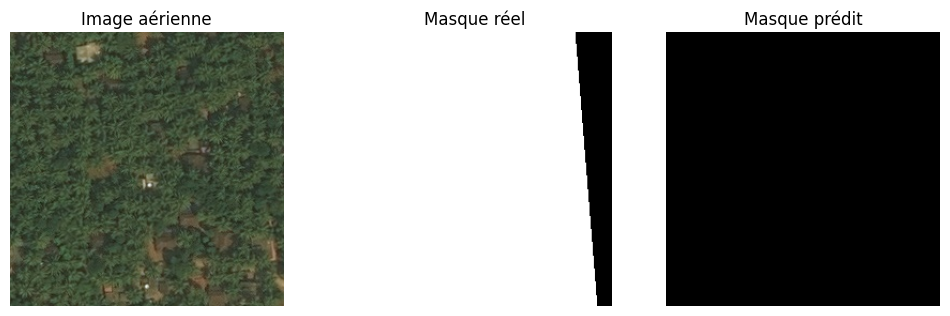

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


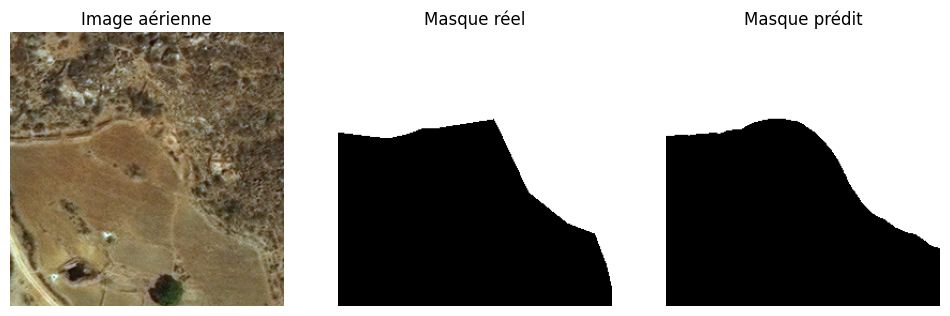

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


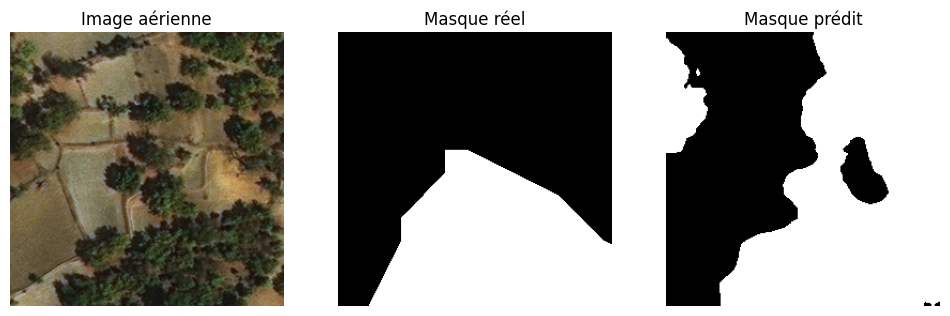

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


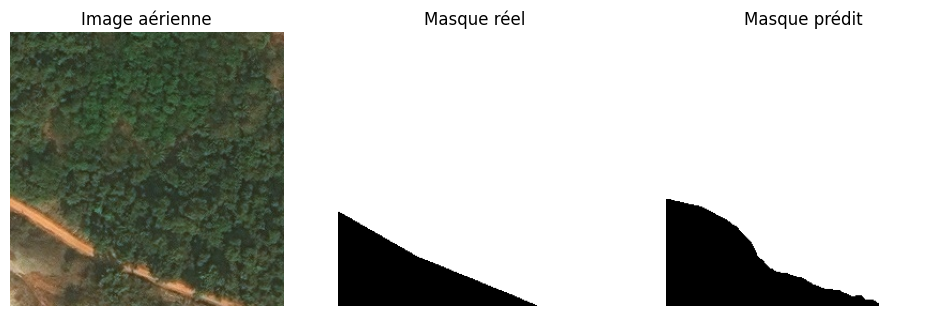

In [26]:
import matplotlib.pyplot as plt

# Prendre quelques images du test set
num_examples = 5
for i in range(num_examples):
    # Charger image et masque réel
    img, mask = test_gen[i]  # img: (batch_size, H, W, 3), mask: (batch_size, H, W, 1)
    
    # On prend la première image du batch
    img_input = img[0][np.newaxis, ...]  # ajouter la dimension batch
    mask_true = mask[0, ..., 0]          # masque réel
    
    # Prédiction
    mask_pred = model.predict(img_input)[0, ..., 0]
    mask_pred = (mask_pred > 0.5).astype(np.uint8)  # binaire
    
    # Affichage
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,3,1)
    plt.imshow(img[0])
    plt.title("Image aérienne")
    plt.axis("off")
    
    plt.subplot(1,3,2)
    plt.imshow(mask_true, cmap="gray")
    plt.title("Masque réel")
    plt.axis("off")
    
    plt.subplot(1,3,3)
    plt.imshow(mask_pred, cmap="gray")
    plt.title("Masque prédit")
    plt.axis("off")
    
    plt.show()


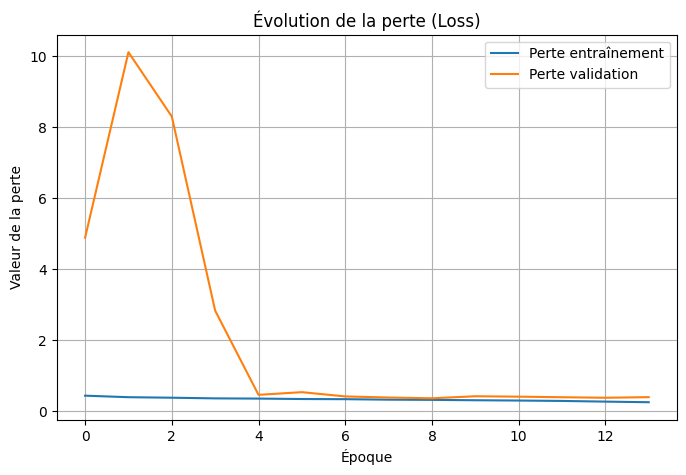

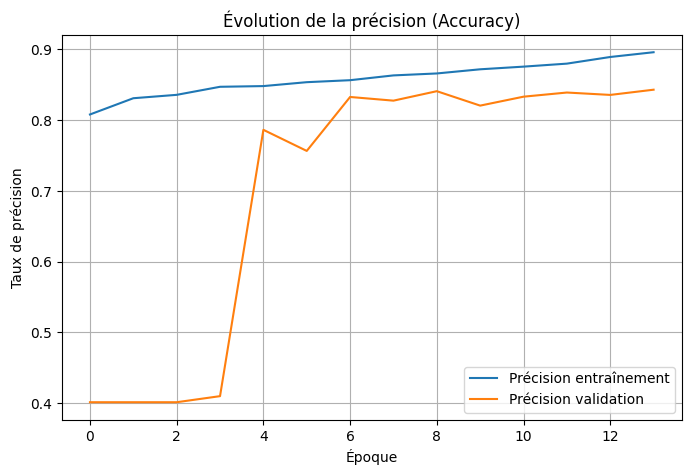

In [27]:
import matplotlib.pyplot as plt

# --- Courbes de perte (Loss) ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title("Évolution de la perte (Loss)")
plt.xlabel("Époque")
plt.ylabel("Valeur de la perte")
plt.legend()
plt.grid(True)
plt.show()

# --- Courbes de précision (Accuracy) ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.title("Évolution de la précision (Accuracy)")
plt.xlabel("Époque")
plt.ylabel("Taux de précision")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


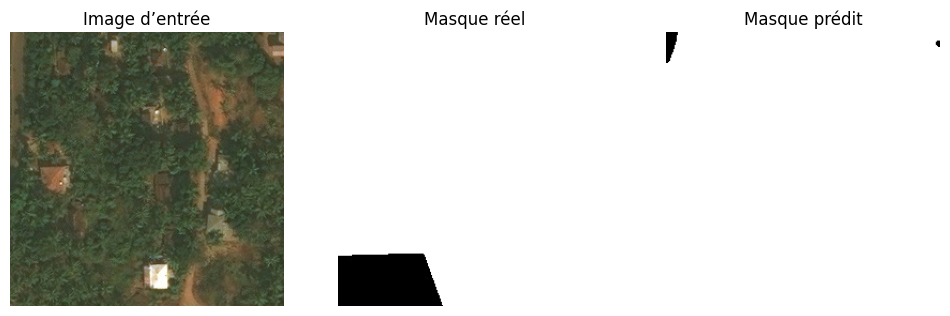

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


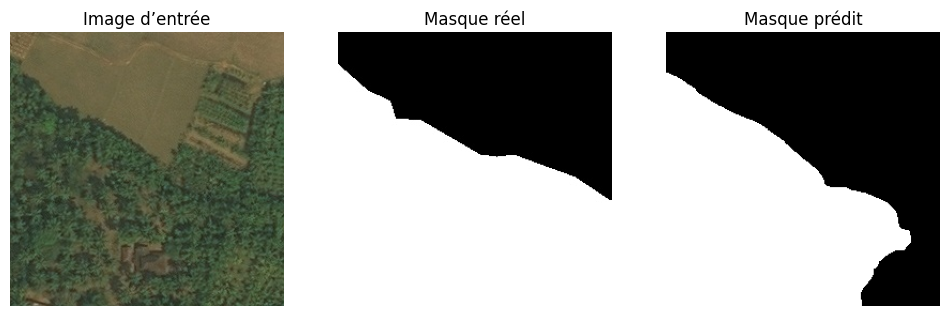

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


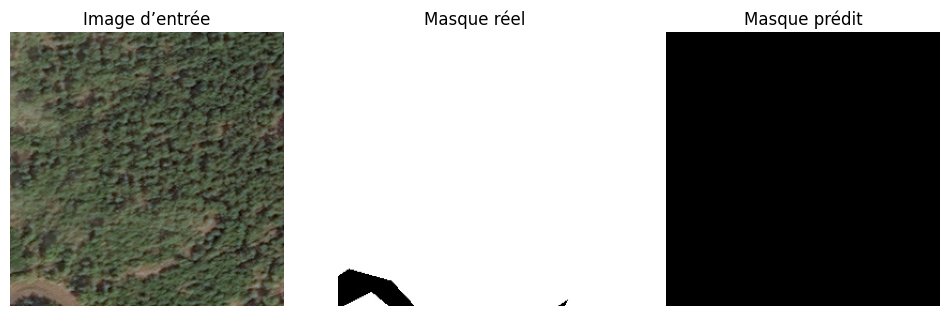

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Fonction pour prédire et afficher ---
def visualize_predictions(model, image_paths, mask_paths, num_samples=3):
    """
    Affiche quelques images avec leur masque réel et le masque prédit par le modèle.
    """
    for i in range(num_samples):
        # Sélectionner une image et son masque
        img_path = image_paths[i]
        mask_path = mask_paths[i]

        # Charger et prétraiter l’image
        img = np.array(load_img(img_path, target_size=(256, 256))) / 255.0
        mask = np.array(load_img(mask_path, target_size=(256, 256), color_mode="grayscale")) / 255.0

        # Ajouter une dimension batch pour la prédiction
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

        # Seuil pour convertir en masque binaire (0 ou 1)
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        # Affichage côte à côte
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Image d’entrée")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap="gray")
        plt.title("Masque réel")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title("Masque prédit")
        plt.axis("off")

        plt.show()

# --- Utilisation avec ton dataset de test ---
visualize_predictions(model, test_img, test_mask, num_samples=3)


In [29]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score

# ==========================
# 🔹 Fonctions de métriques
# ==========================
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# ==========================
# 🔹 Évaluation sur le test set
# ==========================
# Récupération du premier batch test
X_test, Y_test = test_gen[0]
Y_pred = model.predict(X_test)
Y_pred_bin = (Y_pred > 0.5).astype(np.float32)

# ==========================
# 🔹 Calcul des métriques
# ==========================
iou = iou_metric(Y_test, Y_pred_bin)
dice = dice_coef(Y_test, Y_pred_bin)
precision = precision_score(Y_test.flatten(), Y_pred_bin.flatten())
recall = recall_score(Y_test.flatten(), Y_pred_bin.flatten())

# Évaluation pour récupérer la loss
eval_result = model.evaluate(X_test, Y_test, verbose=0)
loss_value = eval_result[0]  # index 0 = loss

# ==========================
# 🔹 Affichage des résultats
# ==========================
print(f"IoU (Intersection over Union): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Loss: {loss_value:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
IoU (Intersection over Union): 0.8093
Dice Coefficient: 0.8946
Precision: 0.9208
Recall: 0.8698
Loss: 0.2973
